In [28]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [32]:
max_seq_len = 120
embedding_dim = 512

PE shape is (120, 512)


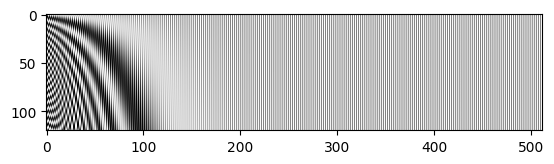

In [33]:
pe = np.array([
    [pos / 10000 ** (2.0 * i / embedding_dim) for i in range(embedding_dim)]
 for pos in range(max_seq_len)])
print(f'PE shape is {pe.shape}')

pe[:, 0::2] = np.sin(pe[:, 0::2])
pe[:, 1::2] = np.cos(pe[:, 1::2])
pe_show = cv2.normalize(pe, None, 0, 1, cv2.NORM_MINMAX)
plt.imshow(pe, cmap='gray')

In [34]:
word_embedding = np.random.random((10, 512))

In [ ]:
def layer_norm(x):
    """
    x.shape = (length, dim)
    """
    mu = np.mean(x, axis=1)
    std = np.std(x, axis=1)

    return (x - mu) / std


def softmax(vec):
    return np.exp(vec) / np.sum(np.exp(vec))


def scaled_dot_product_attention(q, k, v):
    """
    q.shape = (head, -1, per_head_dim)
    """
    scale = np.sqrt(embedding_dim)
    attention = np.matmul(q, k.transpose((0, 2, 1))) / scale
    attention = softmax(attention)

    return np.matmul(attention, v)


def multihead_attention(x, heads=8):
    per_head_dim = embedding_dim // heads

    w_q = np.random.random((embedding_dim, embedding_dim))
    w_k = np.random.random((embedding_dim, embedding_dim))
    w_v = np.random.random((embedding_dim, embedding_dim))

    q = np.matmul(x, w_q).reshape(heads, -1, per_head_dim)
    k = np.matmul(x, w_k).reshape(heads, -1, per_head_dim)
    v = np.matmul(x, w_v).reshape(heads, -1, per_head_dim)

    context = scaled_dot_product_attention(q, k, v)

    return context
    

def add_and_norm(x):
    return x + layer_norm(x)


def fc(x):
    w = np.random.random((embedding_dim, embedding_dim))
    return np.matmul(x, w)